# Part 2 | Multi-Factor Analysis
*An Analysis of Fama and French 5 Faktor Model with Momentum (and ESG Factor) on several ETFs on a 10-year time horizon*

In [369]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import requests
import json
from PIL import Image
from lxml import etree
import sqlite3
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
import warnings
from scipy import stats
from bs4 import BeautifulSoup
import os
import mplfinance as mpf
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import ipynb.fs.defs.Part1_ESG_Factor_Establishment
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## 1. Data Collection and Portfolio Construction

### 1.1 Import data

In [370]:
# Importing data of esg scores of each stock we investigate
esg_score_import = pd.read_csv('__data/esg_score.csv', delimiter=",") 

# Importing data of closing prices of each stock we investigate
price_close_import = pd.read_csv('__data/price_close.csv', delimiter=",")

### 1.2 Selection of portfolios

The portfolios selected for factor analysis encompass a diverse range of investment strategies and market segments:

ESG-Focused Portfolios

1. Best ESG score portfolio
2. Worst ESG score portfolio

Global Market Portfolios

3. VT: Vanguard Total World Stock ETF
4. VEU: Vanguard FTSE All-World ex-US ETF

U.S. Market Segmented Portfolios

5. IVV: iShares Core S&P 500 ETF
6. IJH: iShares Core S&P Mid-Cap ETF
7. IJR: iShares Core S&P Small-Cap ETF

### 1.3 Establishment of portfolios

In [404]:
# Setup function to create esg portfolio
def create_esg_portfolio(esg_score_data, price_close_data, price_close_returns, percentile, high=True):
    portfolio = getESGScorePercentile(esg_score_data, percentile, high)
    
    returns = []
    esg_factors = []
    closing_prices = []
    
    for date in portfolio.index:
        stock_list = portfolio.loc[date, 'Stock_List']
        
        # Calculate average return for the portfolio
        stock_returns = getPortfolioReturn(price_close_returns, date, stock_list)
        avg_return = stock_returns.mean() if len(stock_returns) > 0 else float('nan')
        
        # Calculate average ESG score for the portfolio
        esg_scores = esg_score_data.loc[date, stock_list]
        avg_esg_score = esg_scores.mean() if len(esg_scores) > 0 else float('nan')
        
        # Get closing prices for the stocks in the portfolio
        stock_prices = price_close_data.loc[date, stock_list].to_dict()
        
        returns.append(avg_return)
        esg_factors.append(avg_esg_score)
        closing_prices.append(stock_prices)
    
    portfolio['Return'] = returns
    portfolio['ESG_Factor'] = esg_factors
    portfolio['Closing_Prices'] = closing_prices

    # Remove the first row (which will have NaN for return) and reset the index
    portfolio = portfolio.iloc[1:].reset_index()
    
    return portfolio

In [405]:
'''
FUNCTIONS FROM PART 1
''' 

# Change data type of date to datetime
esg_score_import["Date"] = pd.to_datetime(esg_score_import["Date"])
price_close_import["Date"] = pd.to_datetime(price_close_import["Date"])

# Sort columns alphabetically
esg_score_import = esg_score_import[sorted(esg_score_import.columns)]
price_close_import = price_close_import[sorted(price_close_import.columns)]

# Get one row per month
esg_score = esg_score_import.resample("M", on = "Date").mean() # ME or M
price_close = price_close_import.resample("M", on = "Date").mean() # ME or M

# Drop columns that are not in both tables
common_columns = esg_score.columns.intersection(price_close.columns).tolist()

esg_score = esg_score[common_columns]
price_close = price_close[common_columns]

# Fill missing rows with previous values for esg score
esg_score.fillna(method='ffill', inplace=True)

price_close_returns = price_close.drop(columns=["Date"], errors='ignore').pct_change()

# Function Returns the Portfolio with the ESG Score of a certain percentile for each date
def getESGScorePercentile(esg_score_data, percentile, high = True):
    stock_list = []

    # Loops over each date
    for date in esg_score_data.index:
        esg_scores = esg_score_data.loc[date] # Gets corresponding esg scores
        esg_scores = esg_scores.dropna(axis=0) # Drops any missing values

        # Creates Portfolio
        if high:
            percentile_stocks = esg_scores.nlargest(int(len(esg_scores) * percentile / 100)).index.tolist()
        else:
            percentile_stocks = esg_scores.nsmallest(int(len(esg_scores) * percentile / 100)).index.tolist()

        # Counts stocks in portfolio
        count = len(percentile_stocks)

        # Appends to list
        stock_list.append((date, percentile_stocks, count))

    # Creates new dataframe
    stock_list_dataframe = pd.DataFrame(stock_list, columns=['Date', 'Stock_List', 'Stock_Count'])
    stock_list_dataframe.set_index("Date", inplace = True)

    # Returns dataframe
    return stock_list_dataframe

# Calculates portfolio return for a specific date & list of stocks
def getPortfolioReturn(return_data, date, list_stocks):
    returns = return_data.loc[date]
    returns = returns[list_stocks]

    return returns

# Calculates return history
def calculateReturnHistory(return_data, portfolio_data, column_name_return, column_name_count):

    average_returns = []

    # Loops over each date
    for date in portfolio_data.index:

        # Gets list of stocks & count of stocks
        currentStockList = portfolio_data.loc[date]["Stock_List"]
        currentStockCount = portfolio_data.loc[date]["Stock_Count"]

        # Gets return of list of stocks at current date
        stock_returns = getPortfolioReturn(return_data, date, currentStockList)

        # Calculates average return (EQUAL WEIGHTED)
        if len(stock_returns) > 0:
            average_portfolio_return = stock_returns.mean()
        else:
            average_portfolio_return = float('nan')

        # Adds return to list
        average_returns.append((date, average_portfolio_return, currentStockCount))

    # Returns dataframe
    return pd.DataFrame(average_returns, columns=["Date", column_name_return, column_name_count])

ESG-Focused Portfolios

In [373]:
# Create portfolios with 10% highest and 10% lowest ESG scores
high_esg_portf = create_esg_portfolio(esg_score, price_close, price_close_returns, 10, high=True)
low_esg_portf = create_esg_portfolio(esg_score, price_close, price_close_returns, 10, high=False)

### 1.4 Loading and preprocessing other portfolios

Global Market Portfolios

In [ ]:
def preprocess(asset_name, start_date="2009-11-01", end_date="2024-11-01"):
    # Create 'data' folder if it doesn't exist
    data_folder = '__data'
    os.makedirs(data_folder, exist_ok=True)
    
    # Define the CSV filename
    csv_filename = os.path.join(data_folder, f'{asset_name.lower()}_data.csv')
    
    # Check if the CSV file already exists
    if not os.path.exists(csv_filename):
        # Download the data
        asset_data = yf.download(asset_name, start=start_date, end=end_date)
        # Reset the index to make the date a column
        asset_reset = asset_data.reset_index()
        # Rename the 'Date' column (which is now the first column)
        asset_reset = asset_reset.rename(columns={'Date': 'Date'})
        # Save to CSV file, skipping the first row (header) and without including the index
        asset_reset.to_csv(csv_filename, index=False, header=False)
    
    # Read the CSV file
    df = pd.read_csv(csv_filename, names=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    
    # Convert the 'Date' column to datetime and set it as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Sort the index in ascending order
    df = df.sort_index()
    
    # Ensure we have the 'Close' column
    if 'Close' not in df.columns:
        raise ValueError("DataFrame is missing the 'Close' column")
    
    # Calculate returns and add a 'Return' column
    df['Return'] = df['Close'].pct_change()
    
    # Remove the first row (which will have NaN for return)
    df = df.iloc[1:]
    
    # Keep only 'Date', 'Close', and 'Return' columns
    df = df[['Close', 'Return']].reset_index()
    
    return df

In [377]:
# Process each dataset
vt = preprocess("VT")
veu = preprocess("VEU")

U.S. Market Portfolios

In [379]:
# Process each dataset
ivv = preprocess("IVV")
ijh = preprocess("IJH")
ijr = preprocess("IJR")

### 1.5 Visualizing data

In [380]:
def plot_returns(df1, df2=None, df3=None, months=12):
    plt.figure(figsize=(10, 6))
    
    dfs = [df for df in [df1, df2, df3] if df is not None]
    
    for i, df in enumerate(dfs):
        # Filter data for the last specified number of months
        last_n_months = df.set_index('Date').last(f'{months}M')
        
        # Plot the returns for each dataframe
        label = f'Portfolio {i+1}' if not hasattr(df, 'name') else df.name
        sns.lineplot(x=last_n_months.index, y='Return', data=last_n_months, label=label)
    
    # Adding labels and title
    plt.title(f'Returns Over the Last {months} Months')
    plt.xlabel('Date')
    plt.ylabel('Return')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    
    plt.grid(visible=False)
    plt.xlim(last_n_months.index.min(), last_n_months.index.max())
    
    plt.show()

ESG data

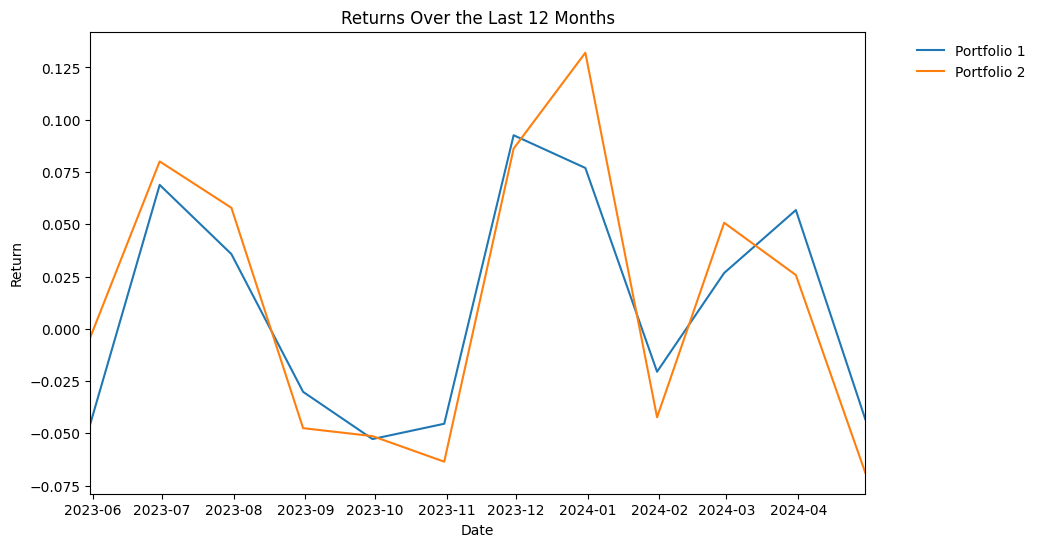

In [381]:
plot_returns(high_esg_portf, low_esg_portf) #monthly data

Global Market Portfolios

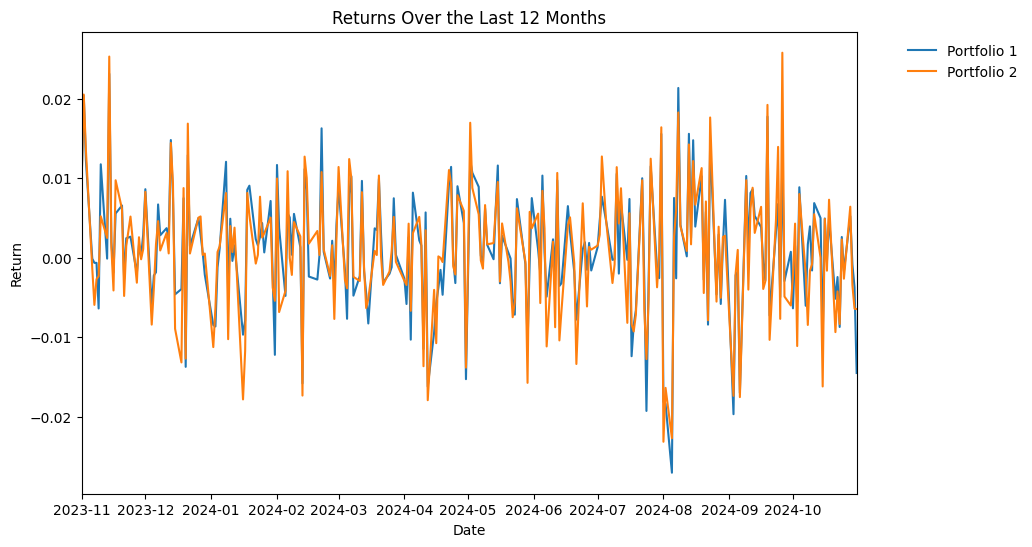

In [382]:
# Plot each dataset
plot_returns(vt, veu)

U.S. Market Portfolios

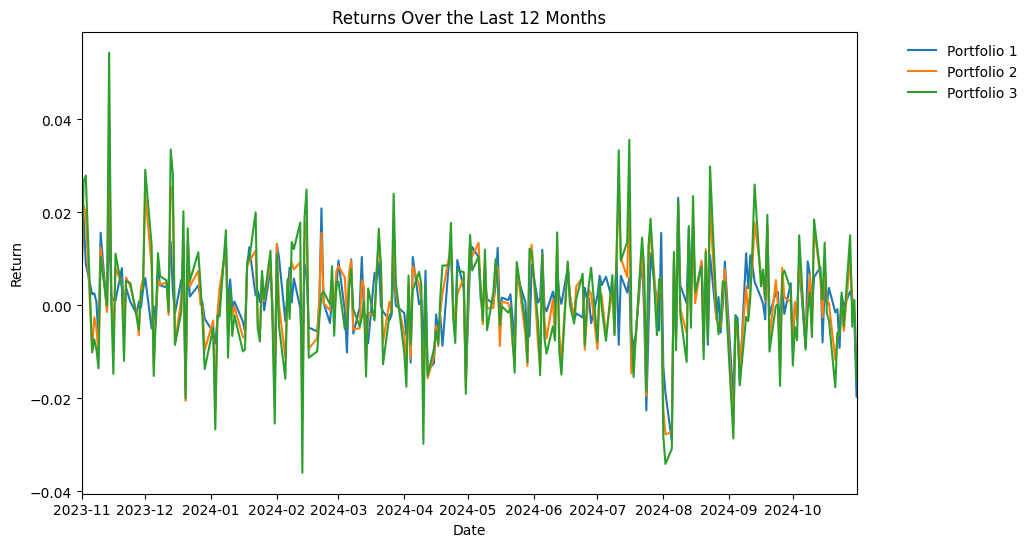

In [383]:
# Plot each dataset
plot_returns(ivv, ijh, ijr)

## 2. Fama and French 5-factor data analysis
10-year time window (starting from 2024-10-02)

### 2.1 Import and Tidy FF5 data

In [ ]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=2, index_col=0)

# Convert the index to datetime 
ff5.index = pd.to_datetime(ff5.index, format='%Y%m%d')

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')

# Drop observations older than 2009-10-02
ff5 = ff5[ff5.index >= '2014-10-02']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index

# Sort columns and drop index
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]     
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
print(ff5.head())

        Date  Mkt-RF   SMB   HML   RMW   CMA   RF
0 2014-10-02    0.15  0.97 -0.38 -0.29 -0.31  0.0
1 2014-10-03    1.08 -0.40 -0.44 -0.10 -0.09  0.0
2 2014-10-06   -0.26 -0.77  0.37  0.32  0.13  0.0
3 2014-10-07   -1.56 -0.14  0.13  0.25  0.03  0.0
4 2014-10-08    1.70 -0.01 -0.06 -0.05 -0.05  0.0


In [385]:
# Rename columns to include a prefix (e.g., 'return_vt', 'return_veu')
def rename(df, prefix):
    # Ensure 'Date' is a column, not an index
    if 'Date' not in df.columns:
        df = df.reset_index() 
    # Rename columns
    rename_dict = {
        'Return': f'return_{prefix}',
        'Close': f'close_{prefix}'
    }
    df = df.rename(columns=rename_dict)
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    return df[['Date'] + list(rename_dict.values())]

In [386]:
vt = rename(vt, 'vt')
veu = rename(veu, 'veu')
ivv = rename(ivv, 'ivv')
ijh = rename(ijh, 'ijh')
ijr = rename(ijr, 'ijr')

In [387]:
vt.head()

,Date,return_vt,close_vt
0,2014-11-04,-0.003623,60.509998
1,2014-11-05,0.002314,60.650002
2,2014-11-06,0.000659,60.689999
3,2014-11-07,0.000659,60.730000
4,2014-11-10,0.002964,60.910000


In [388]:
def rename_esg(df, prefix):
    # Ensure 'Date' is a column, not an index
    if 'Date' not in df.columns:
        df = df.reset_index() 
    # Rename columns
    rename_dict = {
        'Return': f'return_{prefix}'
    }
    df = df.rename(columns=rename_dict)
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    return df[['Date'] + list(rename_dict.values())]

In [389]:
high_esg_portf = rename_esg(high_esg_portf, 'high_esg')
low_esg_portf = rename_esg(low_esg_portf, 'low_esg')

### 2.2 Merge data

In [390]:
# Merge all datasets on the Date column
data = pd.merge(low_esg_portf, high_esg_portf, on='Date', how='inner')
data = pd.merge(data, vt, on='Date', how='inner')
data = pd.merge(data, veu, on='Date', how='inner')
data = pd.merge(data, ivv, on='Date', how='inner')
data = pd.merge(data, ijh, on='Date', how='inner')
data = pd.merge(data, ijr, on='Date', how='inner')
data = pd.merge(data, ff5, on='Date', how='inner')

# Display the first few rows and column names of the resulting dataframe
data.head()

,Date,return_low_esg,return_high_esg,return_vt,close_vt,return_veu,close_veu,return_ivv,close_ivv,return_ijh,close_ijh,return_ijr,close_ijr,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2014-12-31,-0.010755,0.002635,-0.007757,60.119999,-0.004461,46.860001,-0.010239,206.869995,-0.010388,28.959999,-0.006186,57.029999,-0.93,0.48,-0.40,-0.13,-0.19,0.0
1,2015-03-31,-0.016495,-0.008293,-0.007093,61.590000,-0.010156,48.730000,-0.008539,207.830002,-0.003279,30.396000,-0.003882,59.014999,-0.75,0.44,0.38,0.17,0.20,0.0
2,2015-04-30,0.025609,-0.001120,-0.010342,63.160000,-0.010277,51.040001,-0.010095,209.850006,-0.011350,29.964001,-0.018805,57.654999,-1.11,-1.02,0.73,0.25,0.42,0.0
3,2015-06-30,-0.010320,-0.026387,0.002608,61.520000,0.001031,48.549999,0.002370,207.220001,0.002205,29.996000,0.001614,58.939999,0.34,0.28,-0.65,-0.31,-0.59,0.0
4,2015-07-31,-0.004049,0.005640,0.000971,61.830002,0.005609,48.410000,-0.001415,211.759995,0.001201,30.002001,0.004986,58.450001,-0.15,0.74,-1.01,0.24,-0.08,0.0


In [391]:
#Len data 
len(data)

80

### 2.5 Compute Momentum (3, 6 and 12 months) for each portfolio

In [392]:
def calculate_monthly_momentum(data, return_column, lookback_months):
    # Resample to monthly returns
    monthly_returns = (1 + data[return_column]).resample('M').prod() - 1
    
    # Calculate cumulative return over the lookback period
    return (1 + monthly_returns).rolling(window=lookback_months).apply(lambda x: x.prod()) - 1

Compute momentum for esg porfolios 

In [393]:
def add_esg_momentum_factors(data):
    # Ensure 'Date' is in datetime format and set as index
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
    elif not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'Date' column or a DatetimeIndex")

    esg_portfolios = ['low_esg', 'high_esg']
    lookbacks = {
        '12m': 12,  # 12 months lookback
        '6m': 6,    # 6 months lookback
        '3m': 3     # 3 months lookback
    }
    
    # Ensure the data is sorted by date
    data = data.sort_index()
    
    for portfolio in esg_portfolios:
        return_column = f'return_{portfolio}'
        
        for period, lookback in lookbacks.items():
            momentum_column = f'momentum_{period}_{portfolio}'
            monthly_momentum = calculate_monthly_momentum(data, return_column, lookback)
            
            # Forward fill the monthly momentum to daily frequency
            data[momentum_column] = monthly_momentum.reindex(data.index).ffill()
    
    # Remove the first row (which will have NaN for return) and reset the index
    data = data.iloc[1:].reset_index()        
    
    return data

data = add_esg_momentum_factors(data)
data.head()

,Date,return_low_esg,return_high_esg,return_vt,close_vt,return_veu,close_veu,return_ivv,close_ivv,return_ijh,...,HML,RMW,CMA,RF,momentum_12m_low_esg,momentum_6m_low_esg,momentum_3m_low_esg,momentum_12m_high_esg,momentum_6m_high_esg,momentum_3m_high_esg
0,2015-03-31,-0.016495,-0.008293,-0.007093,61.590000,-0.010156,48.730000,-0.008539,207.830002,-0.003279,...,0.38,0.17,0.20,0.0,NaN,NaN,-0.016495,NaN,NaN,-0.008293
1,2015-04-30,0.025609,-0.001120,-0.010342,63.160000,-0.010277,51.040001,-0.010095,209.850006,-0.011350,...,0.73,0.25,0.42,0.0,NaN,NaN,0.008692,NaN,NaN,-0.009403
2,2015-06-30,-0.010320,-0.026387,0.002608,61.520000,0.001031,48.549999,0.002370,207.220001,0.002205,...,-0.65,-0.31,-0.59,0.0,NaN,-0.001718,0.015024,NaN,-0.035543,-0.027478
3,2015-07-31,-0.004049,0.005640,0.000971,61.830002,0.005609,48.410000,-0.001415,211.759995,0.001201,...,-1.01,0.24,-0.08,0.0,NaN,-0.005761,-0.014328,NaN,-0.030103,-0.020897
4,2015-08-31,-0.029368,-0.051036,-0.006368,57.730000,-0.006231,44.660000,-0.008629,198.750000,-0.007012,...,1.42,0.11,0.46,0.0,NaN,-0.034960,-0.043276,NaN,-0.079603,-0.070866


Compute momentum for all other porfolios 

In [395]:
def calculate_monthly_momentum(data, return_column, lookback_months):
    # Resample to monthly returns
    monthly_returns = (1 + data[return_column]).resample('M').prod() - 1
    
    # Calculate cumulative return over the lookback period
    return (1 + monthly_returns).rolling(window=lookback_months).apply(lambda x: x.prod()) - 1

def add_momentum_factors(data):
    # Ensure 'Date' is in datetime format and set as index
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
    elif not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'Date' column or a DatetimeIndex")

    datasets = ['vt', 'veu', 'ivv', 'ijh', 'ijr']
    lookbacks = {
        '12m': 12,  # 12 months lookback
        '6m': 6,    # 6 months lookback
        '3m': 3     # 3 months lookback
    }
    
    # Ensure the data is sorted by date
    data = data.sort_index()
    
    for dataset in datasets:
        return_column = f'return_{dataset}'
        
        # Ensure we have a return column, if not, calculate it from close prices
        if return_column not in data.columns:
            close_column = f'close_{dataset}'
            data[return_column] = data[close_column].pct_change()
        
        for period, lookback in lookbacks.items():
            momentum_column = f'momentum_{period}_{dataset}'
            monthly_momentum = calculate_monthly_momentum(data, return_column, lookback)
            
            # Forward fill the monthly momentum to daily frequency
            data[momentum_column] = monthly_momentum.reindex(data.index).ffill()
    
    # Remove the first row (which will have NaN for return) and reset the index
    data = data.iloc[1:].reset_index()        
    
    return data

data = add_momentum_factors(data)
data.head()

,Date,return_low_esg,return_high_esg,return_vt,close_vt,return_veu,close_veu,return_ivv,close_ivv,return_ijh,...,momentum_3m_veu,momentum_12m_ivv,momentum_6m_ivv,momentum_3m_ivv,momentum_12m_ijh,momentum_6m_ijh,momentum_3m_ijh,momentum_12m_ijr,momentum_6m_ijr,momentum_3m_ijr
0,2015-04-30,0.025609,-0.001120,-0.010342,63.160000,-0.010277,51.040001,-0.010095,209.850006,-0.011350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-06-30,-0.010320,-0.026387,0.002608,61.520000,0.001031,48.549999,0.002370,207.220001,0.002205,...,-0.009257,NaN,NaN,-0.007748,NaN,NaN,-0.009170,NaN,NaN,-0.017221
2,2015-07-31,-0.004049,0.005640,0.000971,61.830002,0.005609,48.410000,-0.001415,211.759995,0.001201,...,0.006645,NaN,NaN,0.000952,NaN,NaN,0.003409,NaN,NaN,0.006609
3,2015-08-31,-0.029368,-0.051036,-0.006368,57.730000,-0.006231,44.660000,-0.008629,198.750000,-0.007012,...,0.000373,NaN,-0.026091,-0.007685,NaN,-0.018166,-0.003627,NaN,-0.016865,0.005883
4,2015-09-30,-0.056209,-0.030819,0.017476,55.310001,0.019857,42.630001,0.019414,192.710007,0.013127,...,0.019187,NaN,0.001368,0.009187,NaN,-0.002005,0.007231,NaN,-0.000750,0.016760


### 2.6 Visualize Momentum of all Portfolios

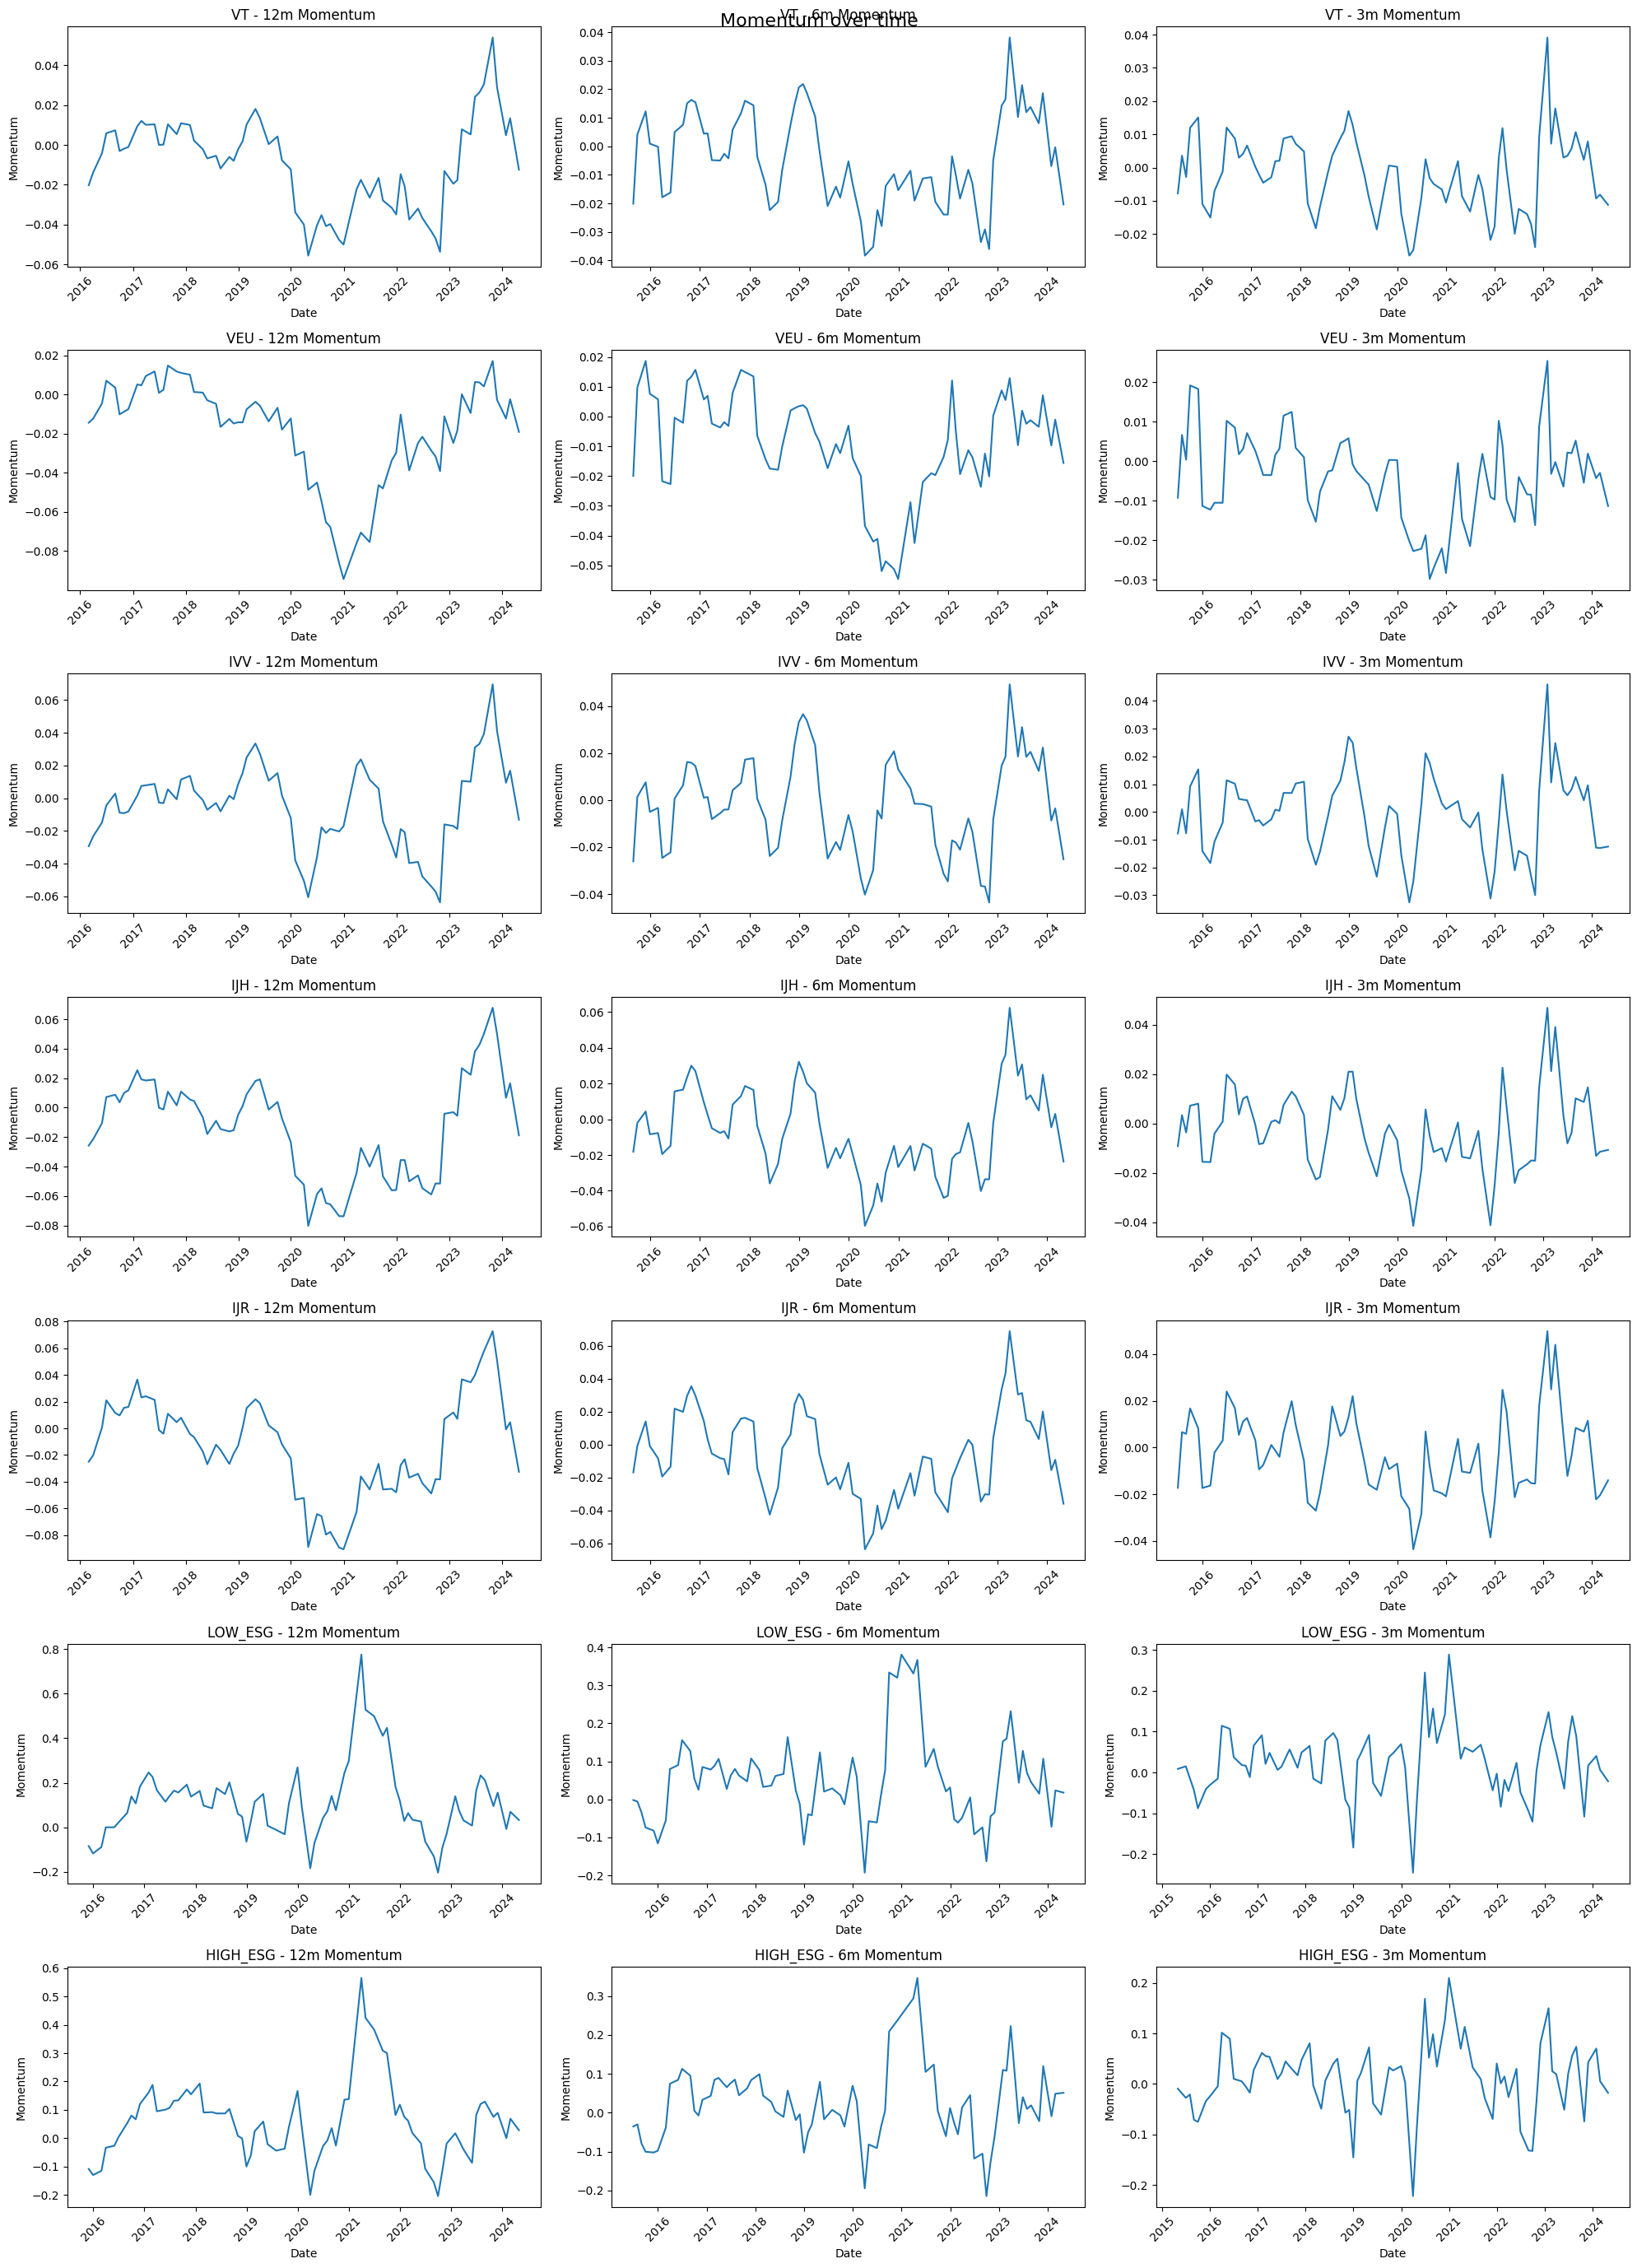

In [397]:
# Plot momentum over time for each dataset and period
fig, axs = plt.subplots(7, 3, figsize=(20, 28))  # Increased to 7 rows
fig.suptitle('Momentum over time', fontsize=16)

datasets = ['vt', 'veu', 'ivv', 'ijh', 'ijr', 'low_esg', 'high_esg']
periods = ['12m', '6m', '3m']

for i, dataset in enumerate(datasets):
    for j, period in enumerate(periods):
        col = f'momentum_{period}_{dataset}'
        axs[i, j].plot(data['Date'], data[col])
        axs[i, j].set_title(f'{dataset.upper()} - {period} Momentum')
        axs[i, j].set_xlabel('Date')
        axs[i, j].set_ylabel('Momentum')
        axs[i, j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('__figures/momentum_over_time.png')
plt.show()

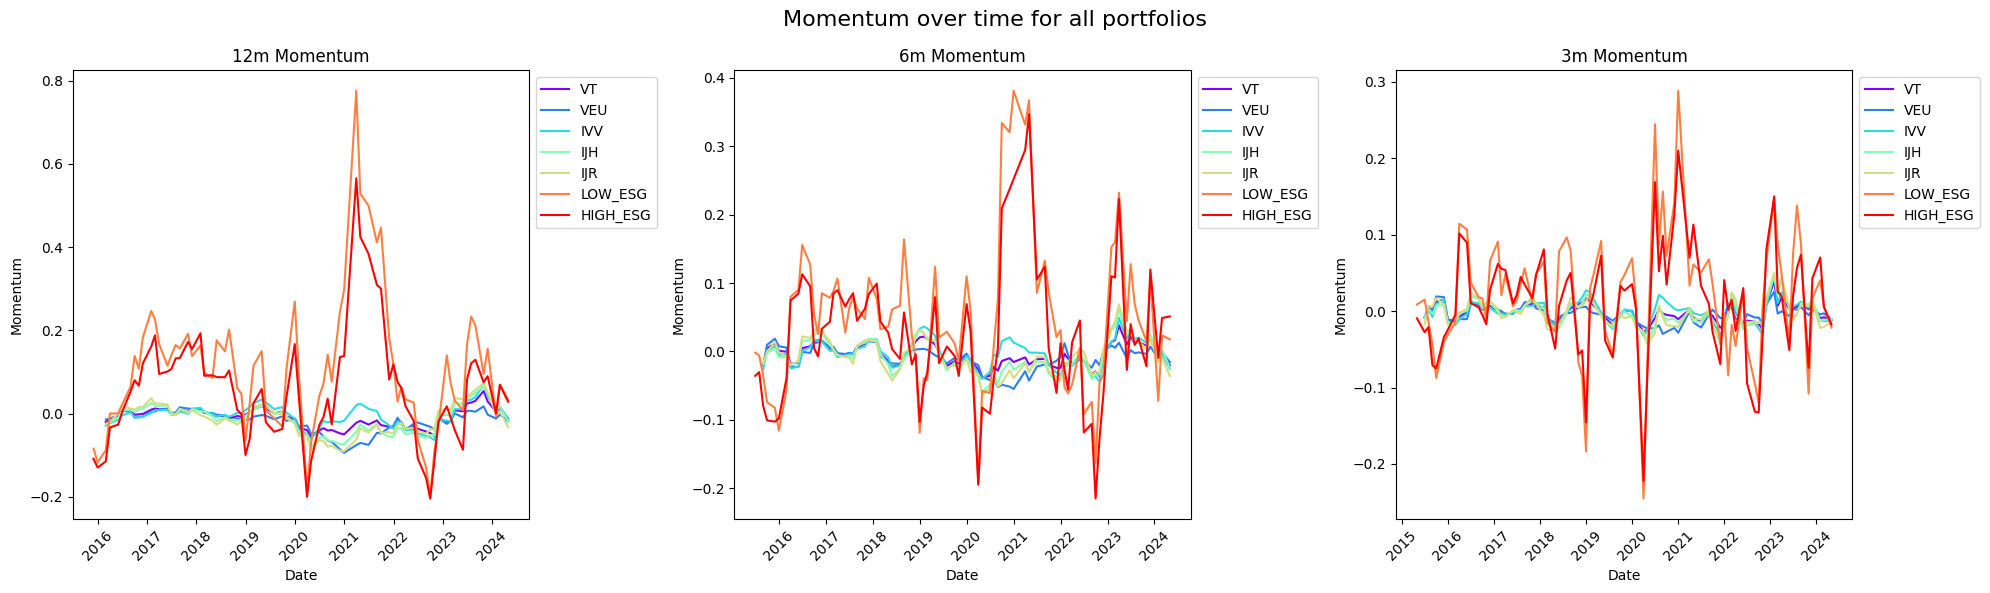

In [398]:
# Define portfolios and momentum periods
portfolios = ['vt', 'veu', 'ivv', 'ijh', 'ijr', 'low_esg', 'high_esg']
momentum_periods = ['12m', '6m', '3m']

# Create a color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(portfolios)))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Momentum over time for all portfolios', fontsize=16)

# Plot for each momentum period
for j, period in enumerate(momentum_periods):
    for i, portfolio in enumerate(portfolios):
        col = f'momentum_{period}_{portfolio}'
        axs[j].plot(data['Date'], data[col], label=portfolio.upper(), color=colors[i])
    
    axs[j].set_title(f'{period} Momentum')
    axs[j].set_xlabel('Date')
    axs[j].set_ylabel('Momentum')
    axs[j].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axs[j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('__figures/momentum_over_time_for_all_portfolios.png')
plt.show()

Each graph shows the momentum of various portfolios (VT, VEU, IVV, IJH, IJR), with the first representing a 12-month window, the second a 6-month window, and the third a 3-month window; all graphs indicate that momentum fluctuates similarly across portfolios, suggesting that they are collectively influenced by broader market trends.


### 2.7 Include ESG Factor data

In [399]:
return_history = pd.read_csv("__data/return_history.csv")
return_history["Date"] = pd.to_datetime(return_history["Date"])
return_history = return_history[["Date", "ESG_Factor"]]
return_history.head()

,Date,ESG_Factor
0,2002-01-31,-0.117420
1,2002-02-28,-0.051034
2,2002-03-31,-0.016283
3,2002-04-30,-0.048415
4,2002-05-31,-0.018426


In [400]:
data = pd.merge(data, return_history, on='Date', how='inner')
print(data)
print("\nColumns in the merged dataset:")
print(data.columns.tolist())

         Date  return_low_esg  return_high_esg  return_vt    close_vt  \
0  2015-04-30        0.025609        -0.001120  -0.010342   63.160000   
1  2015-06-30       -0.010320        -0.026387   0.002608   61.520000   
2  2015-07-31       -0.004049         0.005640   0.000971   61.830002   
3  2015-08-31       -0.029368        -0.051036  -0.006368   57.730000   
4  2015-09-30       -0.056209        -0.030819   0.017476   55.310001   
..        ...             ...              ...        ...         ...   
73 2023-10-31       -0.063550        -0.045409   0.004888   90.459999   
74 2023-11-30        0.086191         0.092574   0.002950   98.610001   
75 2024-01-31       -0.042321        -0.020534  -0.012194  102.879997   
76 2024-02-29        0.050730         0.026697   0.004110  107.500000   
77 2024-04-30       -0.068825        -0.043216  -0.015251  106.540001   

    return_veu  close_veu  return_ivv   close_ivv  return_ijh  ...  \
0    -0.010277  51.040001   -0.010095  209.850006   -

### 2.8 Conduct FF5 including Momentum and ESG-Factor and Visualize Correlation with Heatmap


Processing VT:
Columns in the dataframe: ['Date', 'return_low_esg', 'return_high_esg', 'return_vt', 'close_vt', 'return_veu', 'close_veu', 'return_ivv', 'close_ivv', 'return_ijh', 'close_ijh', 'return_ijr', 'close_ijr', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'momentum_12m_low_esg', 'momentum_6m_low_esg', 'momentum_3m_low_esg', 'momentum_12m_high_esg', 'momentum_6m_high_esg', 'momentum_3m_high_esg', 'momentum_12m_vt', 'momentum_6m_vt', 'momentum_3m_vt', 'momentum_12m_veu', 'momentum_6m_veu', 'momentum_3m_veu', 'momentum_12m_ivv', 'momentum_6m_ivv', 'momentum_3m_ivv', 'momentum_12m_ijh', 'momentum_6m_ijh', 'momentum_3m_ijh', 'momentum_12m_ijr', 'momentum_6m_ijr', 'momentum_3m_ijr', 'ESG_Factor']
Rows with NaN values removed: 11
Remaining observations: 71

Regression results for VT - Fama-French 5-factor model with Momentum and ESG:
                            OLS Regression Results                            
Dep. Variable:       Excess_Return_vt   R-squared:                       

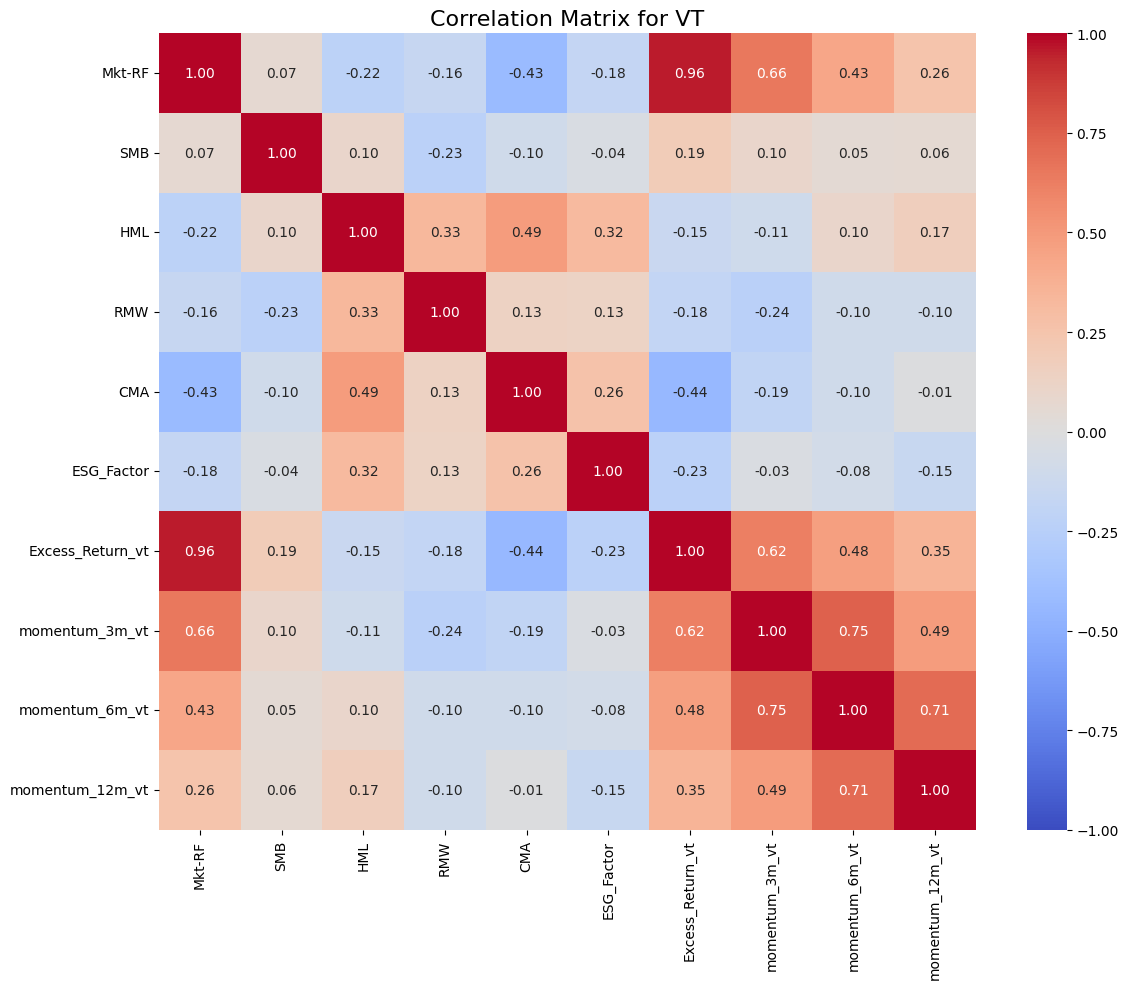


Correlation Matrix:
                    Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF            1.000000  0.068039 -0.219388 -0.163488 -0.425622   
SMB               0.068039  1.000000  0.098397 -0.232489 -0.097905   
HML              -0.219388  0.098397  1.000000  0.330024  0.489544   
RMW              -0.163488 -0.232489  0.330024  1.000000  0.133160   
CMA              -0.425622 -0.097905  0.489544  0.133160  1.000000   
ESG_Factor       -0.175105 -0.036582  0.317194  0.129289  0.260559   
Excess_Return_vt  0.957907  0.189547 -0.147946 -0.183002 -0.438658   
momentum_3m_vt    0.655495  0.095831 -0.106064 -0.242051 -0.190584   
momentum_6m_vt    0.434732  0.054530  0.099743 -0.099610 -0.095278   
momentum_12m_vt   0.255303  0.056755  0.166202 -0.097293 -0.013122   

                  ESG_Factor  Excess_Return_vt  momentum_3m_vt  \
Mkt-RF             -0.175105          0.957907        0.655495   
SMB                -0.036582          0.189547        0.095831   
HML       

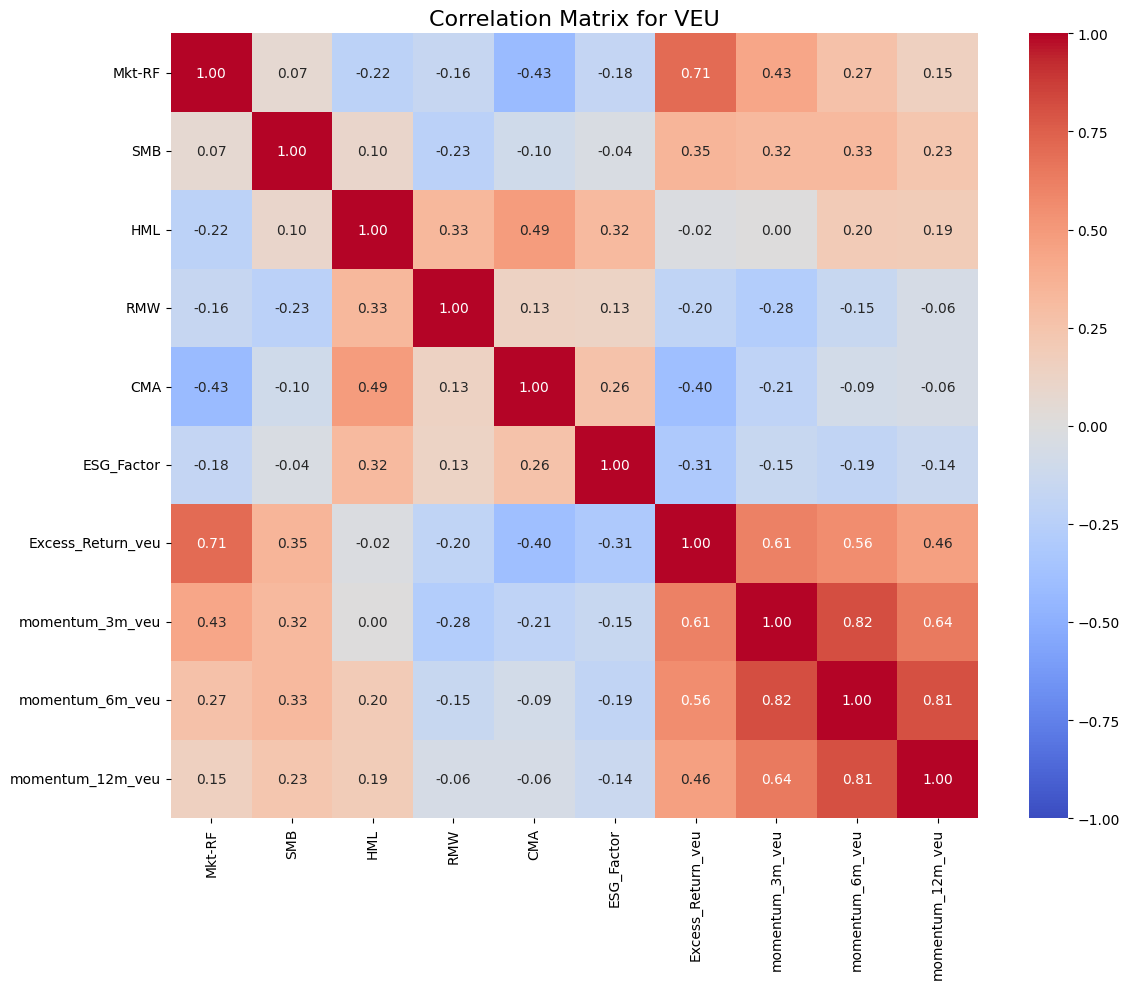


Correlation Matrix:
                     Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF             1.000000  0.068039 -0.219388 -0.163488 -0.425622   
SMB                0.068039  1.000000  0.098397 -0.232489 -0.097905   
HML               -0.219388  0.098397  1.000000  0.330024  0.489544   
RMW               -0.163488 -0.232489  0.330024  1.000000  0.133160   
CMA               -0.425622 -0.097905  0.489544  0.133160  1.000000   
ESG_Factor        -0.175105 -0.036582  0.317194  0.129289  0.260559   
Excess_Return_veu  0.708385  0.349834 -0.018297 -0.196912 -0.395670   
momentum_3m_veu    0.430535  0.323003  0.003361 -0.281142 -0.205724   
momentum_6m_veu    0.266989  0.325534  0.197116 -0.153769 -0.085762   
momentum_12m_veu   0.153573  0.234412  0.190655 -0.060561 -0.056870   

                   ESG_Factor  Excess_Return_veu  momentum_3m_veu  \
Mkt-RF              -0.175105           0.708385         0.430535   
SMB                 -0.036582           0.349834         0.

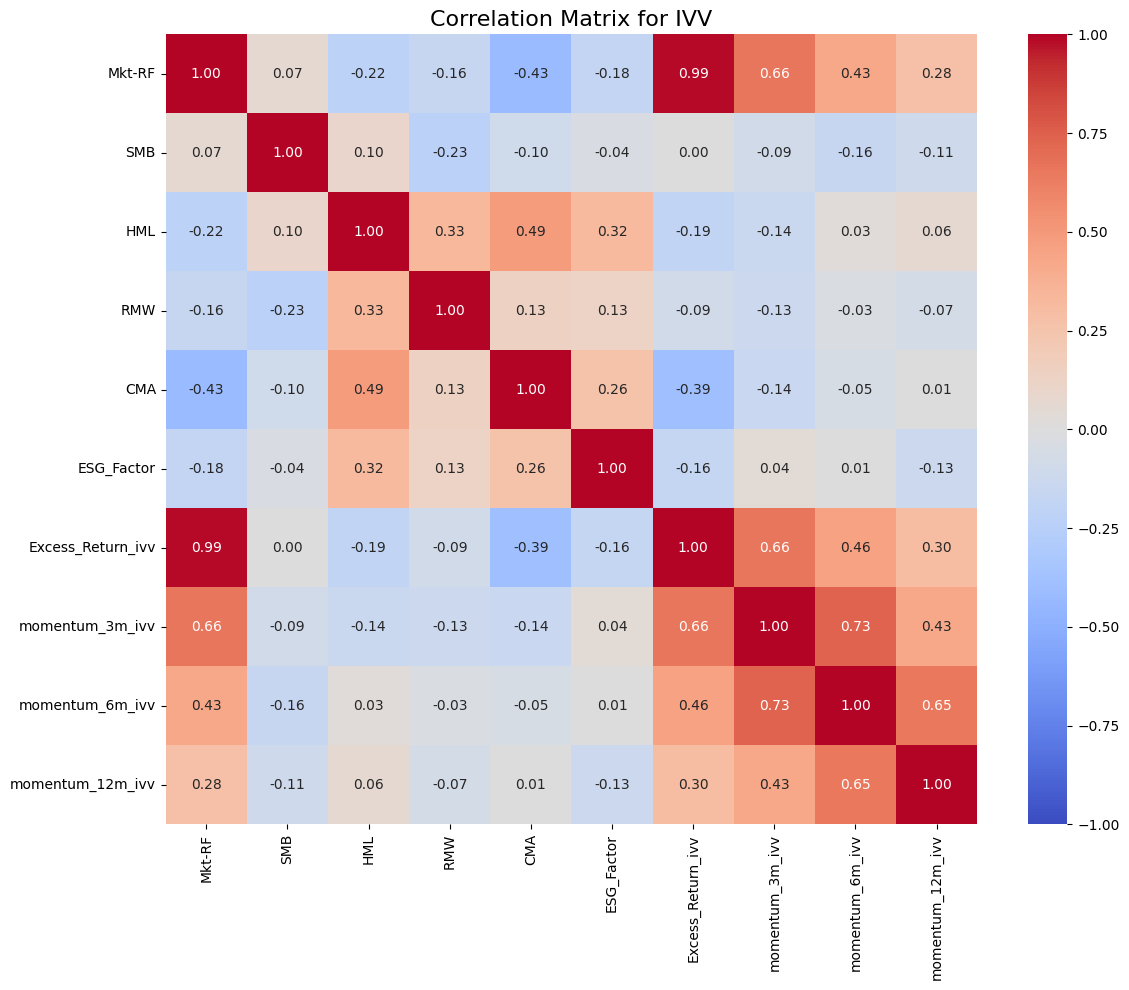


Correlation Matrix:
                     Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF             1.000000  0.068039 -0.219388 -0.163488 -0.425622   
SMB                0.068039  1.000000  0.098397 -0.232489 -0.097905   
HML               -0.219388  0.098397  1.000000  0.330024  0.489544   
RMW               -0.163488 -0.232489  0.330024  1.000000  0.133160   
CMA               -0.425622 -0.097905  0.489544  0.133160  1.000000   
ESG_Factor        -0.175105 -0.036582  0.317194  0.129289  0.260559   
Excess_Return_ivv  0.991661  0.002894 -0.193471 -0.091387 -0.392624   
momentum_3m_ivv    0.656373 -0.092931 -0.138567 -0.128334 -0.143542   
momentum_6m_ivv    0.428511 -0.159652  0.025614 -0.028587 -0.052649   
momentum_12m_ivv   0.275727 -0.106402  0.062966 -0.074677  0.007167   

                   ESG_Factor  Excess_Return_ivv  momentum_3m_ivv  \
Mkt-RF              -0.175105           0.991661         0.656373   
SMB                 -0.036582           0.002894        -0.

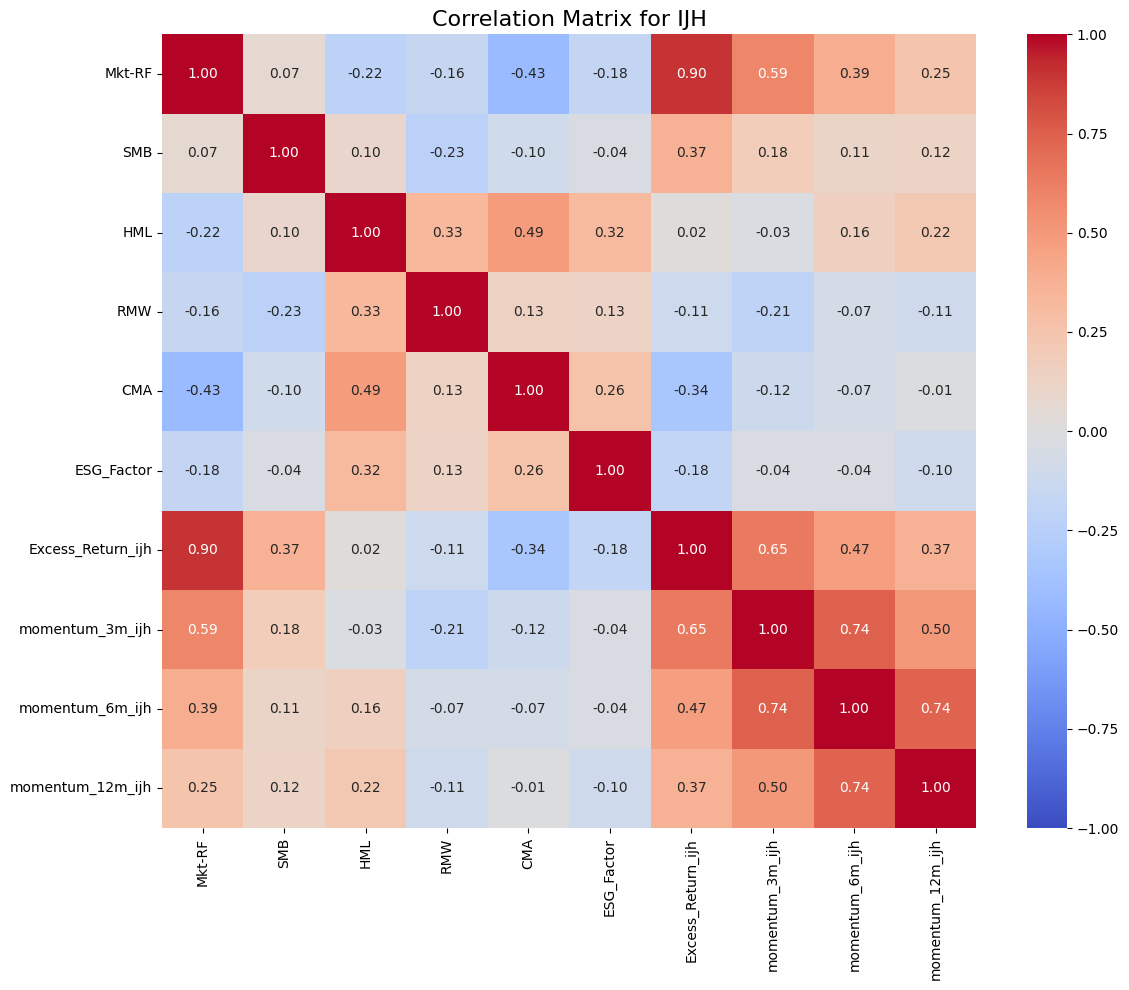


Correlation Matrix:
                     Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF             1.000000  0.068039 -0.219388 -0.163488 -0.425622   
SMB                0.068039  1.000000  0.098397 -0.232489 -0.097905   
HML               -0.219388  0.098397  1.000000  0.330024  0.489544   
RMW               -0.163488 -0.232489  0.330024  1.000000  0.133160   
CMA               -0.425622 -0.097905  0.489544  0.133160  1.000000   
ESG_Factor        -0.175105 -0.036582  0.317194  0.129289  0.260559   
Excess_Return_ijh  0.900548  0.373558  0.021168 -0.112243 -0.342557   
momentum_3m_ijh    0.591895  0.180157 -0.028843 -0.208913 -0.124518   
momentum_6m_ijh    0.391727  0.111612  0.162456 -0.072534 -0.071141   
momentum_12m_ijh   0.252616  0.119933  0.219291 -0.106103 -0.012102   

                   ESG_Factor  Excess_Return_ijh  momentum_3m_ijh  \
Mkt-RF              -0.175105           0.900548         0.591895   
SMB                 -0.036582           0.373558         0.

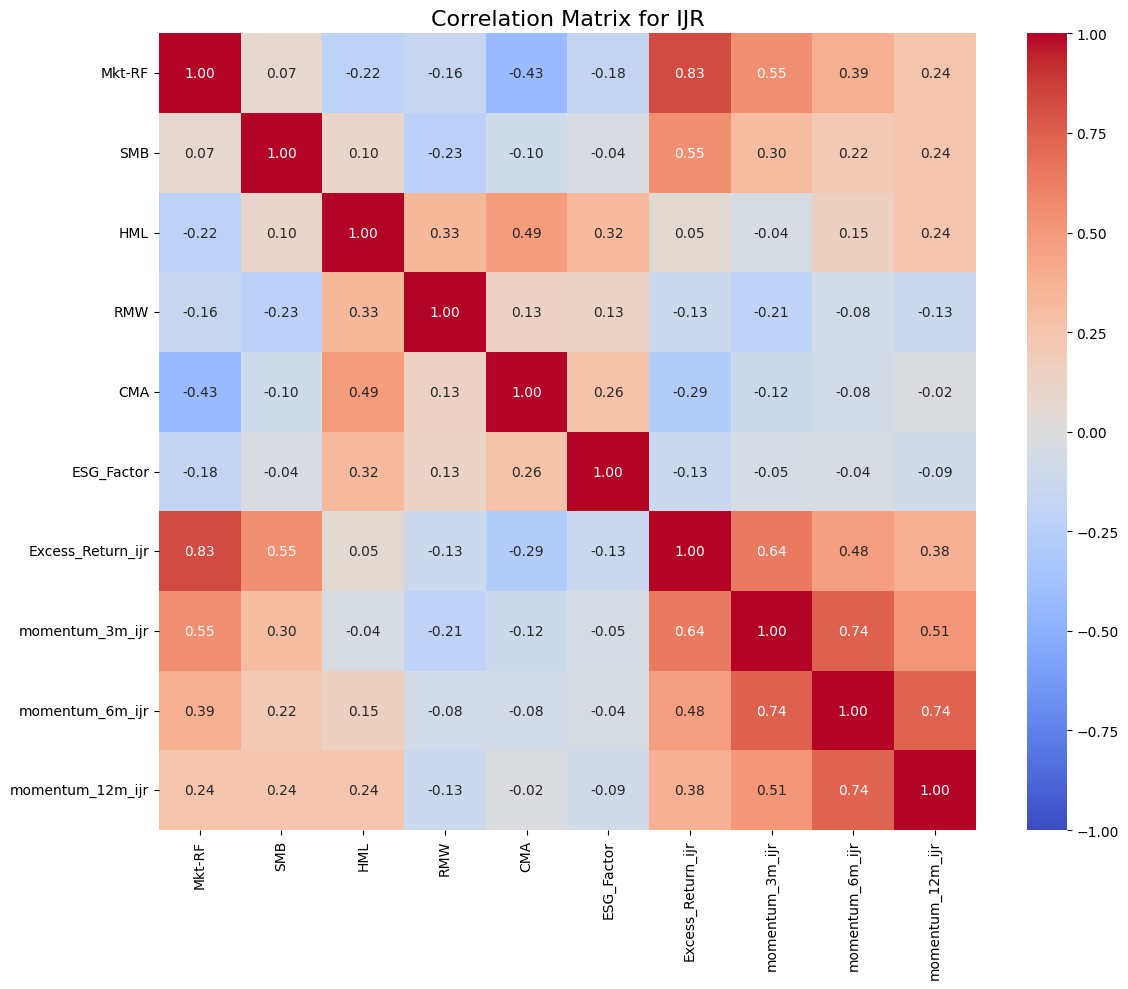


Correlation Matrix:
                     Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF             1.000000  0.068039 -0.219388 -0.163488 -0.425622   
SMB                0.068039  1.000000  0.098397 -0.232489 -0.097905   
HML               -0.219388  0.098397  1.000000  0.330024  0.489544   
RMW               -0.163488 -0.232489  0.330024  1.000000  0.133160   
CMA               -0.425622 -0.097905  0.489544  0.133160  1.000000   
ESG_Factor        -0.175105 -0.036582  0.317194  0.129289  0.260559   
Excess_Return_ijr  0.825330  0.554168  0.047868 -0.126422 -0.287221   
momentum_3m_ijr    0.552238  0.299343 -0.043241 -0.208427 -0.118964   
momentum_6m_ijr    0.386105  0.217452  0.151240 -0.079378 -0.075441   
momentum_12m_ijr   0.242315  0.240240  0.236931 -0.129370 -0.017213   

                   ESG_Factor  Excess_Return_ijr  momentum_3m_ijr  \
Mkt-RF              -0.175105           0.825330         0.552238   
SMB                 -0.036582           0.554168         0.

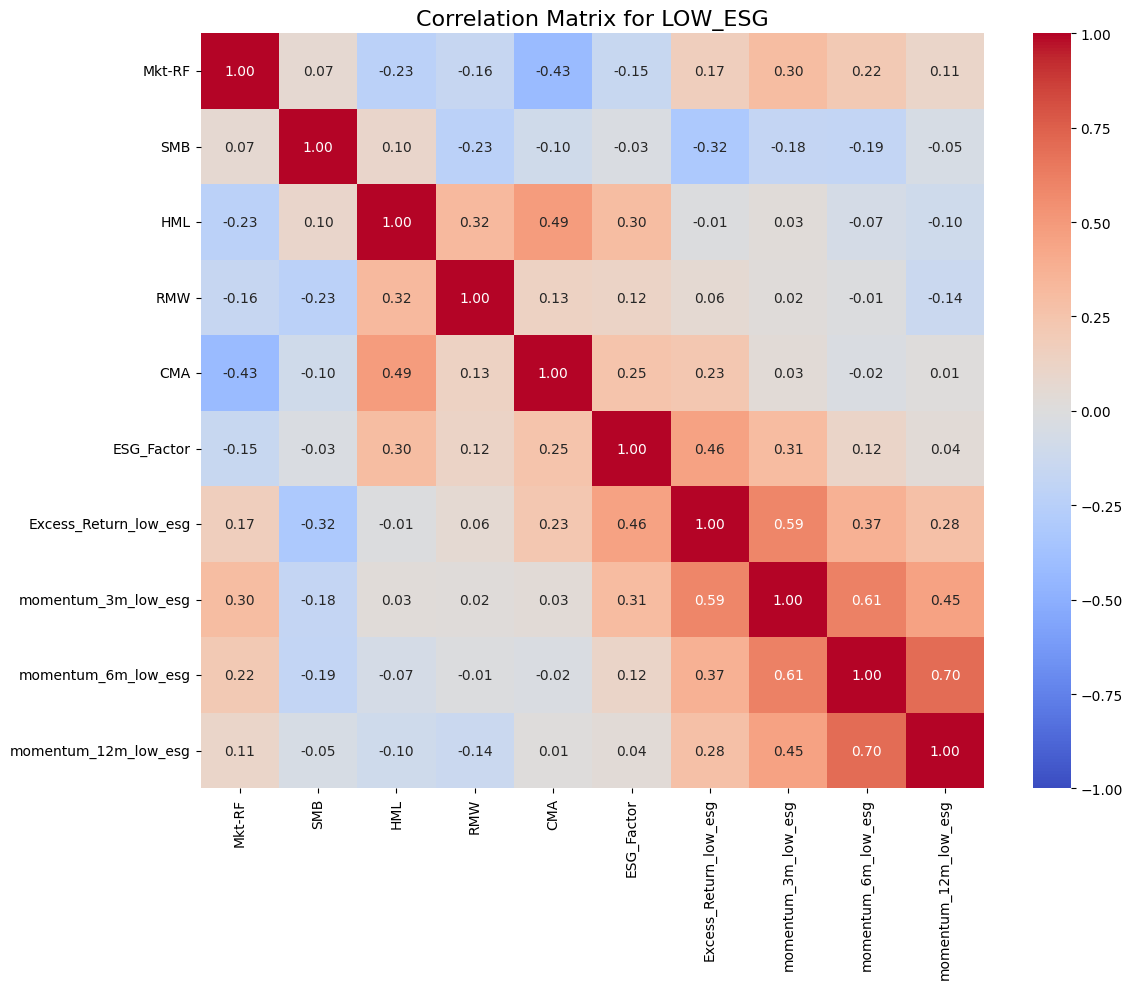


Correlation Matrix:
                         Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF                 1.000000  0.068994 -0.231066 -0.162343 -0.425862   
SMB                    0.068994  1.000000  0.100251 -0.233249 -0.098044   
HML                   -0.231066  0.100251  1.000000  0.323110  0.486349   
RMW                   -0.162343 -0.233249  0.323110  1.000000  0.133066   
CMA                   -0.425862 -0.098044  0.486349  0.133066  1.000000   
ESG_Factor            -0.151981 -0.025356  0.299877  0.122695  0.250067   
Excess_Return_low_esg  0.165588 -0.317485 -0.011994  0.056099  0.228238   
momentum_3m_low_esg    0.297377 -0.176970  0.027021  0.016178  0.031972   
momentum_6m_low_esg    0.217097 -0.186234 -0.066211 -0.012776 -0.024452   
momentum_12m_low_esg   0.108966 -0.049119 -0.103259 -0.140427  0.014303   

                       ESG_Factor  Excess_Return_low_esg  momentum_3m_low_esg  \
Mkt-RF                  -0.151981               0.165588             0.2

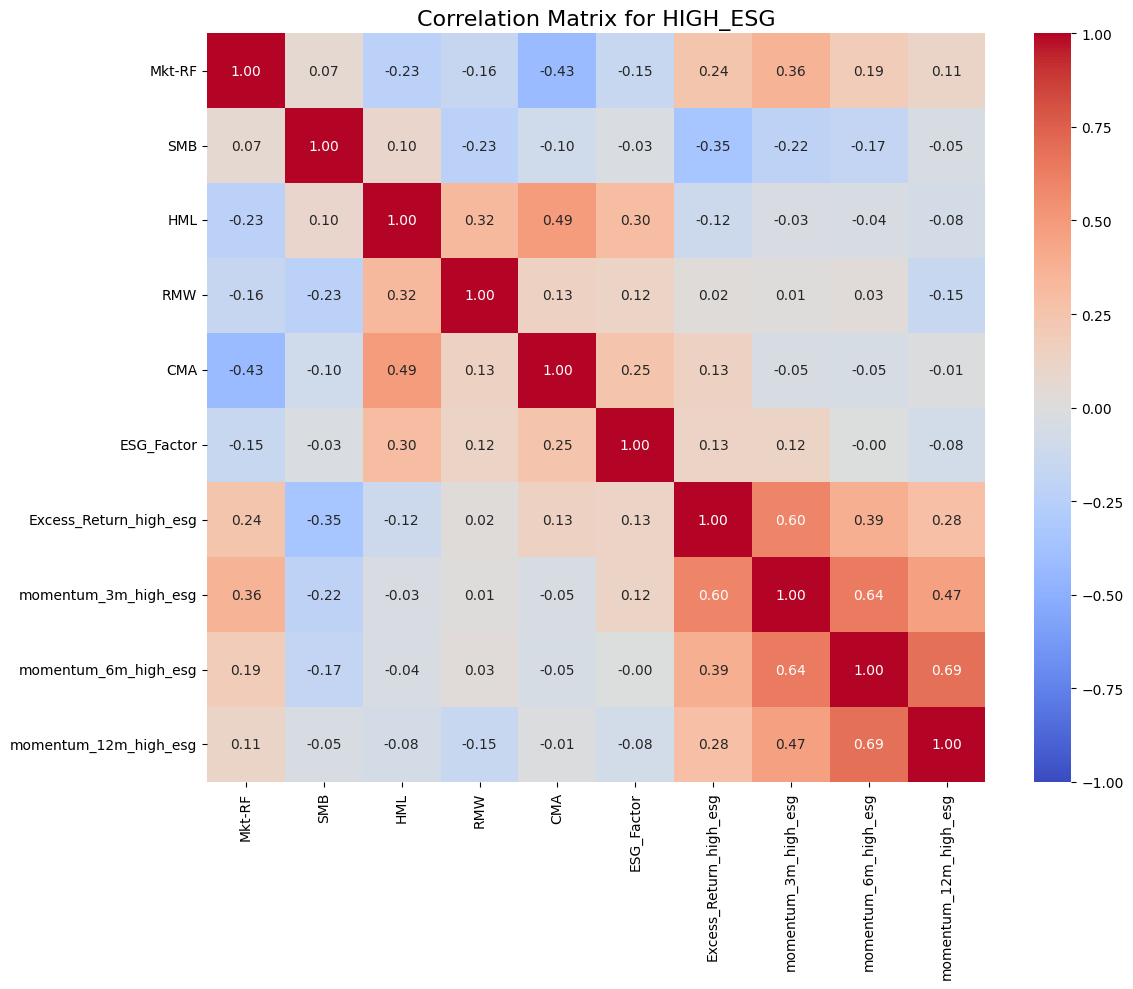


Correlation Matrix:
                          Mkt-RF       SMB       HML       RMW       CMA  \
Mkt-RF                  1.000000  0.068994 -0.231066 -0.162343 -0.425862   
SMB                     0.068994  1.000000  0.100251 -0.233249 -0.098044   
HML                    -0.231066  0.100251  1.000000  0.323110  0.486349   
RMW                    -0.162343 -0.233249  0.323110  1.000000  0.133066   
CMA                    -0.425862 -0.098044  0.486349  0.133066  1.000000   
ESG_Factor             -0.151981 -0.025356  0.299877  0.122695  0.250067   
Excess_Return_high_esg  0.244468 -0.347865 -0.124383  0.020442  0.135000   
momentum_3m_high_esg    0.363110 -0.216327 -0.031650  0.008357 -0.045829   
momentum_6m_high_esg    0.193973 -0.174671 -0.041733  0.029109 -0.047902   
momentum_12m_high_esg   0.113663 -0.045927 -0.077029 -0.150218 -0.010115   

                        ESG_Factor  Excess_Return_high_esg  \
Mkt-RF                   -0.151981                0.244468   
SMB               

In [401]:
def compute_excess_return_run_regression_and_create_heatmap(data, portfolio):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()
        
        print(f"\nProcessing {portfolio.upper()}:")
        print(f"Columns in the dataframe: {df.columns.tolist()}")
        
        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate excess returns
        if portfolio in ['low_esg', 'high_esg']:
            df[f'Excess_Return_{portfolio}'] = df[f'return_{portfolio}'] - df['RF'] / 100
        else:
            # Calculate daily returns if not already present
            if f'return_{portfolio}' not in df.columns:
                df[f'return_{portfolio}'] = df[f'close_{portfolio}'].pct_change()
            df[f'Excess_Return_{portfolio}'] = df[f'return_{portfolio}'] - df['RF'] / 100

        # Prepare factors for regression and correlation
        ff_factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
        portfolio_specific_factors = [
            'ESG_Factor',
            f'Excess_Return_{portfolio}',
            f'momentum_3m_{portfolio}',
            f'momentum_6m_{portfolio}',
            f'momentum_12m_{portfolio}'
        ]
        
        factors = ff_factors + portfolio_specific_factors

        # Check for NaN values in relevant columns
        nan_count_before = df[factors].isnull().sum().sum()
        df = df.dropna(subset=factors)
        nan_count_after = df[factors].isnull().sum().sum()

        print(f"Rows with NaN values removed: {nan_count_before - nan_count_after}")
        print(f"Remaining observations: {len(df)}")

        # Regression analysis
        X = df[factors[:-1]]  # All factors except Excess_Return
        y = df[f'Excess_Return_{portfolio}']
        
        X = sm.add_constant(X)  # Add constant term

        # Run OLS regression
        model = sm.OLS(y, X).fit()
        
        print(f"\nRegression results for {portfolio.upper()} - Fama-French 5-factor model with Momentum and ESG:")
        print(model.summary())

        # Create correlation heatmap
        corr_matrix = df[factors].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
        plt.title(f'Correlation Matrix for {portfolio.upper()}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'__figures/correlation_matrix_{portfolio}.png')
        plt.show()

        print("\nCorrelation Matrix:")
        print(corr_matrix)

        print(f"\nHighly correlated factors for {portfolio.upper()} (|correlation| > 0.5):")
        for i in range(len(factors)):
            for j in range(i+1, len(factors)):
                if abs(corr_matrix.iloc[i, j]) > 0.5:
                    print(f"{factors[i]} and {factors[j]}: {corr_matrix.iloc[i, j]:.2f}")

    except Exception as e:
        print(f"Error processing data for {portfolio}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")
        print("DataFrame info:")
        print(df.info())

# Run the computation, regression, and create heatmap for each portfolio
portfolios = ['vt', 'veu', 'ivv', 'ijh', 'ijr', 'low_esg', 'high_esg']
for portfolio in portfolios:
    compute_excess_return_run_regression_and_create_heatmap(data, portfolio)

## 3. Analysis of results of FF5 including Momentum and ESG-Factor 

### 3.1 Performance analysis

##### Risk-adjusted returns

In [403]:
def calculate_performance_metrics(data, portfolio):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Determine the correct return column name
        if portfolio == 'esg_low':
            return_column = 'return_low_esg'
        elif portfolio == 'esg_high':
            return_column = 'return_high_esg'
        else:
            return_column = f'return_{portfolio}'

        # Calculate excess returns: portfolio returns - Risk-free rate
        df[f'Excess_Return_{portfolio}'] = df[return_column] - df['RF'] / 100  # Assuming RF is in percentage

        # Calculate average return and standard deviation of returns
        avg_return = df[return_column].mean()
        std_return = df[return_column].std()
        
        # Calculate annualized metrics
        risk_free_rate = df['RF'].mean() / 100  # Convert to decimal
        annualized_return = (1 + avg_return) ** 12 - 1  # Assuming monthly data
        annualized_volatility = std_return * np.sqrt(12)  # Assuming monthly data
        
        # Cumulative return
        cumulative_return = (1 + df[return_column]).cumprod().iloc[-1] - 1
        
        print(f"\nPerformance Metrics for {portfolio.upper()}:")
        print(f"1. Annualized Return: {annualized_return:.4f}")
        print(f"2. Cumulative Return: {cumulative_return:.4f}")
        print(f"3. Annualized Volatility: {annualized_volatility:.4f}")

        # 4. Sharpe Ratio
        sharpe_ratio = (avg_return - risk_free_rate/12) / std_return if std_return != 0 else np.nan
        print(f"4. Sharpe Ratio: {sharpe_ratio:.4f}")
        
        # 5. Sortino Ratio (using downside deviation)
        downside_returns = df[return_column][df[return_column] < 0]
        downside_deviation = np.sqrt((downside_returns**2).mean())
        sortino_ratio = (avg_return - risk_free_rate/12) / downside_deviation if downside_deviation != 0 else np.nan
        print(f"5. Sortino Ratio: {sortino_ratio:.4f}")
        
        # 6. Treynor Ratio
        market_return = df['Mkt-RF'].mean() / 100  # Convert to decimal
        X = sm.add_constant(df['Mkt-RF'])
        model = sm.OLS(df[return_column], X).fit()
        beta = model.params[1]
        treynor_ratio = (annualized_return - risk_free_rate) / beta if beta != 0 else np.nan
        print(f"6. Treynor Ratio: {treynor_ratio:.4f}")
        
        # 7. Alpha using CAPM
        alpha = model.params[0]  # The intercept is the alpha
        print(f"7. Alpha: {alpha:.4f}")
        
        # 8. Information Ratio
        tracking_error = np.sqrt(((df[f'Excess_Return_{portfolio}'] - (df['Mkt-RF']/100)).dropna())**2).mean()
        information_ratio = (avg_return - market_return) / tracking_error if tracking_error != 0 else np.nan
        print(f"8. Information Ratio: {information_ratio:.4f}")
        
        # 9. M2 Measure (Modigliani Measure)
        market_volatility = df['Mkt-RF'].std() / 100
        m2_measure = (sharpe_ratio * market_volatility) + risk_free_rate
        print(f"9. M2 Measure: {m2_measure:.4f}")

    except Exception as e:
        print(f"Error processing data for {portfolio}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")
        print("DataFrame columns:")
        print(df.columns.tolist())

# Run performance metrics calculation for each portfolio
portfolios = ['vt', 'veu', 'ivv', 'ijh', 'ijr', 'esg_low', 'esg_high']
for portfolio in portfolios:
    calculate_performance_metrics(data, portfolio)


Performance Metrics for VT:
1. Annualized Return: -0.0142
2. Cumulative Return: -0.0909
3. Annualized Volatility: 0.0286
4. Sharpe Ratio: -0.1443
5. Sortino Ratio: -0.1449
6. Treynor Ratio: -1.7452
7. Alpha: -0.0008
8. Information Ratio: -0.3151
9. M2 Measure: -0.0013

Performance Metrics for VEU:
1. Annualized Return: -0.0258
2. Cumulative Return: -0.1584
3. Annualized Volatility: 0.0282
4. Sharpe Ratio: -0.2683
5. Sortino Ratio: -0.2518
6. Treynor Ratio: -4.2551
7. Alpha: -0.0019
8. Information Ratio: -0.3296
9. M2 Measure: -0.0026

Performance Metrics for IVV:
1. Annualized Return: -0.0086
2. Cumulative Return: -0.0578
3. Annualized Volatility: 0.0325
4. Sharpe Ratio: -0.0773
5. Sortino Ratio: -0.0828
6. Treynor Ratio: -0.9061
7. Alpha: -0.0003
8. Information Ratio: -0.2512
9. M2 Measure: -0.0007

Performance Metrics for IJH:
1. Annualized Return: -0.0196
2. Cumulative Return: -0.1247
3. Annualized Volatility: 0.0371
4. Sharpe Ratio: -0.1547
5. Sortino Ratio: -0.1415
6. Treynor Rat

Based on the performance metrics provided, a clear pattern emerges:

The ESG-focused portfolios, particularly the ESG_LOW (worst ESG score) portfolio, significantly outperformed the other portfolios across most metrics. The ESG_LOW portfolio showed the highest annualized return (15.78%) and cumulative return (122.01%), while the ESG_HIGH (best ESG score) portfolio also performed well with an 8.28% annualized return. In contrast, the global and U.S. market portfolios all exhibited negative returns and lower performance metrics overall.

This data suggests that, contrary to some expectations, portfolios with lower ESG scores outperformed those with higher ESG scores during this period. However, it's important to note that both ESG-focused portfolios delivered positive returns while traditional market indices struggled, indicating that ESG considerations may have provided some level of downside protection in challenging market conditions.

Factor-Adjusted Performance

In [66]:
def calculate_fama_french_alpha(data, portfolio):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Determine the correct return column name
        if portfolio == 'esg_low':
            return_column = 'return_low_esg'
        elif portfolio == 'esg_high':
            return_column = 'return_high_esg'
        else:
            return_column = f'return_{portfolio}'

        # Calculate excess returns: portfolio returns - risk-free rate
        df[f'Excess_Return_{portfolio}'] = df[return_column] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression (using 5-factor model)
        X = df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].dropna()  # Independent variables
        y = df[f'Excess_Return_{portfolio}'].dropna()   # Dependent variable

        # Align X and y to ensure they have the same index after dropping NaN values
        common_index = X.index.intersection(y.index)
        X = X.loc[common_index]
        y = y.loc[common_index]

        # Add constant term for regression
        X = sm.add_constant(X)

        # Run OLS regression
        model = sm.OLS(y, X).fit()

        # Extract alpha (intercept) and factor loadings
        alpha = model.params['const']
        beta_mkt = model.params['Mkt-RF']
        beta_smb = model.params['SMB']
        beta_hml = model.params['HML']
        beta_rmw = model.params['RMW']
        beta_cma = model.params['CMA']
        
        print(f"\nFama-French 5-Factor Model Results for {portfolio.upper()}:")
        print(f"Alpha: {alpha:.6f}")
        print(f"Beta (Market): {beta_mkt:.6f}")
        print(f"Beta (SMB): {beta_smb:.6f}")
        print(f"Beta (HML): {beta_hml:.6f}")
        print(f"Beta (RMW): {beta_rmw:.6f}")
        print(f"Beta (CMA): {beta_cma:.6f}")
        print(f"R-squared: {model.rsquared:.6f}")
        print(f"Adjusted R-squared: {model.rsquared_adj:.6f}")

        # Calculate and print t-statistics and p-values
        print("\nt-statistics:")
        print(model.tvalues)
        print("\np-values:")
        print(model.pvalues)

    except Exception as e:
        print(f"Error processing data for {portfolio}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")
        print("DataFrame columns:")
        print(df.columns.tolist())

# Run Fama-French Alpha calculation for each portfolio
portfolios = ['vt', 'veu', 'ivv', 'ijh', 'ijr', 'esg_low', 'esg_high']
for portfolio in portfolios:
    calculate_fama_french_alpha(data, portfolio)


Fama-French 5-Factor Model Results for VT:
Alpha: -0.000676
Beta (Market): 0.007996
Beta (SMB): 0.001265
Beta (HML): 0.000873
Beta (RMW): -0.000382
Beta (CMA): -0.001145
R-squared: 0.940836
Adjusted R-squared: 0.936839

t-statistics:
const     -2.680364
Mkt-RF    29.690423
SMB        3.336144
HML        2.355253
RMW       -0.755494
CMA       -1.846041
dtype: float64

p-values:
const     9.060636e-03
Mkt-RF    7.508678e-43
SMB       1.330776e-03
HML       2.116280e-02
RMW       4.523508e-01
CMA       6.888569e-02
dtype: float64

Fama-French 5-Factor Model Results for VEU:
Alpha: -0.001627
Beta (Market): 0.005643
Beta (SMB): 0.002855
Beta (HML): 0.001875
Beta (RMW): -0.001127
Beta (CMA): -0.002923
R-squared: 0.633186
Adjusted R-squared: 0.608401

t-statistics:
const    -2.632566
Mkt-RF    8.553768
SMB       3.074349
HML       2.063632
RMW      -0.909097
CMA      -1.924388
dtype: float64

p-values:
const     1.031000e-02
Mkt-RF    1.160364e-12
SMB       2.954024e-03
HML       4.255998e-0

##### 3.2 Robustness Check

Time-Varying Factor Exposures